# (1) Train predicator (classifier) for AFA 
The AFA problem contains the training of a classifier that is able to predict well based on any acquired subset of features. 
In this notebook we train and save such a classifier 

In [1]:
%load_ext autoreload
%autoreload 2

## Define paths

Paths for data

In [27]:
from afa.configurations.utils_ts import specify_default_paths_ts
# which dataset to work on 
dataset_name   = "synthetic_1"
dataset_name   = "miiv"

# name for of missingness scenario, if there is none put in None
miss_scenario  = 'MCAR_1'
miss_scenario = None

# automatically specify some path locations (change paths manually if needed) 
paths = specify_default_paths_ts(dataset_name = dataset_name , miss_scenario = miss_scenario) 

paths['data_file']          = '../../../data/ts/miiv/fully_observed/miiv_static.parquet'
paths['temporal_data_file'] = '../../../data/ts/miiv/fully_observed/miiv_ts_wide.parquet'

Paths for model

In [28]:
# name for predictor 
predictor_model_name  = 'logistic_regression'

# new (where to save the model) 
predictor_model_dir = paths['data_dir'] + 'predictor_models' + '/' + predictor_model_name + '/'

## Load dataset with missingness 
At first, we want to load the dataset 

Includes loading: 
- superfeature mapping
- problem
- afa_problem 
- missingness_model

In [4]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

2023-03-01 15:34:45.475278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 15:35:03.233740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 15:35:03.233756: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-01 15:36:16.066015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [32]:
data_loader = DataLoader_ts(     data_file                  = paths['data_file'],
                                 temporal_data_file         = paths['temporal_data_file'],
                                 superfeature_mapping_file  = paths['superfeature_mapping_file'],
                                 problem_file               = paths['problem_file'],
                                 afa_problem_files          = paths['afa_problem_files'], 
                                 miss_model_files           = paths['miss_model_files'], 
                                 folds_file                 = paths['folds_file'] )
dataset = data_loader.load(temporal_is_wide=True, temporal_only_nrows=None) 

Padding sequence: 100%|██████████| 67056/67056 [03:02<00:00, 368.03it/s]


## Create afa dataset with missingness 
To train an AFA predictor, we need to induce artificial missingness (such that the predictor is robust to the missingness pattern). 
Here, we use a simple model to create missingness randomly (MCAR).

In [30]:
from afa.afa_datasets.utils_ts import create_MCAR_afa_dataset_ts

In [33]:
MCAR_ratio = 0.9   # Probability of being obsered, 1 - MCAR_ration is the prob. of being missing
n_samples = 5      # how many times to induce missingness ???
afa_dataset = create_MCAR_afa_dataset_ts( dataset, MCAR_ratio=MCAR_ratio, n_samples=n_samples)

Change base_model to stationary_constant
Change base_model to stationary_constant
Set weight for constant stationary model ...
Set weight for constant stationary model ...


## Train Predictor 

### Initialize predictor 

In [34]:
from afa.afa_models.afa_predictors.afa_predictor_ts import AFAPredictor_ts

In [35]:
predictor_model_params = {
    'name' : predictor_model_name, 
    'directory': predictor_model_dir,
    'base_model_params' : {   'model_type': 'ImputeThenRegress',
                              'imputer_params' : 
                                       {   
                                      'model_type': 'simple_imputer',
                                      'mode' : 'imputation'
                                      },
                              'predictor_params' : 
                                       {   
                                      'model_type': 'ann',
                                      'mode' : 'classification',
                                      'units':              1,
                                      'layers': 1,
                                      'learning_rate': 0.01,
                                      'batch_size' :128,
                                      'epochs': 100 
                                      }
                          }
    }

In [36]:
afa_predictor = AFAPredictor_ts(    name            = predictor_model_params['name'], 
                                    model_params    = predictor_model_params, 
                                    directory       = predictor_model_params['directory'])   

2023-03-01 16:24:41.229316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 16:24:41.230297: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 16:24:41.257144: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-01 16:24:41.257637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-01 16:24:41.293867: W tensorflow/c

2023-03-01 16:24:58.586566: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-01 16:24:58.586584: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-01 16:24:58.606841: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-03-01 16:24:58.626579: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-03-01 16:24:58.655943: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-01 16:24:58.655992: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/100
 25/943 [..............................] - ETA: 1s - loss: 106.4885 - binary_accuracy: 0.5266       

2023-03-01 16:25:03.415597: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-01 16:25:03.415615: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-01 16:25:03.489385: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-01 16:25:03.489540: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


173/943 [====>.........................] - ETA: 1s - loss: 19.4799 - binary_accuracy: 0.9194

2023-03-01 16:25:03.618180: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-03-01 16:25:03.618544: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-01 16:25:03.708969: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: ../../../data/ts/miiv/fully_observed/predictor_models/logistic_regression/logs/20230301-162458/plugins/profile/2023_03_01_16_25_03/ws-211009.xplane.pb


943/943 [==============================] - 4s 1ms/step - loss: 4.3364 - binary_accuracy: 0.9651 - val_loss: 0.2245 - val_binary_accuracy: 0.9667
Epoch 2/100
943/943 [==============================] - 1s 783us/step - loss: 0.6558 - binary_accuracy: 0.9763 - val_loss: 0.0996 - val_binary_accuracy: 0.9847
Epoch 3/100
943/943 [==============================] - 1s 778us/step - loss: 0.7841 - binary_accuracy: 0.9771 - val_loss: 0.8731 - val_binary_accuracy: 0.9856
Epoch 4/100
943/943 [==============================] - 1s 780us/step - loss: 0.6458 - binary_accuracy: 0.9793 - val_loss: 0.9260 - val_binary_accuracy: 0.9630
Epoch 5/100
943/943 [==============================] - 1s 780us/step - loss: 0.6805 - binary_accuracy: 0.9772 - val_loss: 0.2517 - val_binary_accuracy: 0.9854
Epoch 6/100
943/943 [==============================] - 1s 793us/step - loss: 0.9706 - binary_accuracy: 0.9761 - val_loss: 2.6678 - val_binary_accuracy: 0.9856
Epoch 7/100
943/943 [==============================] - 1s 78

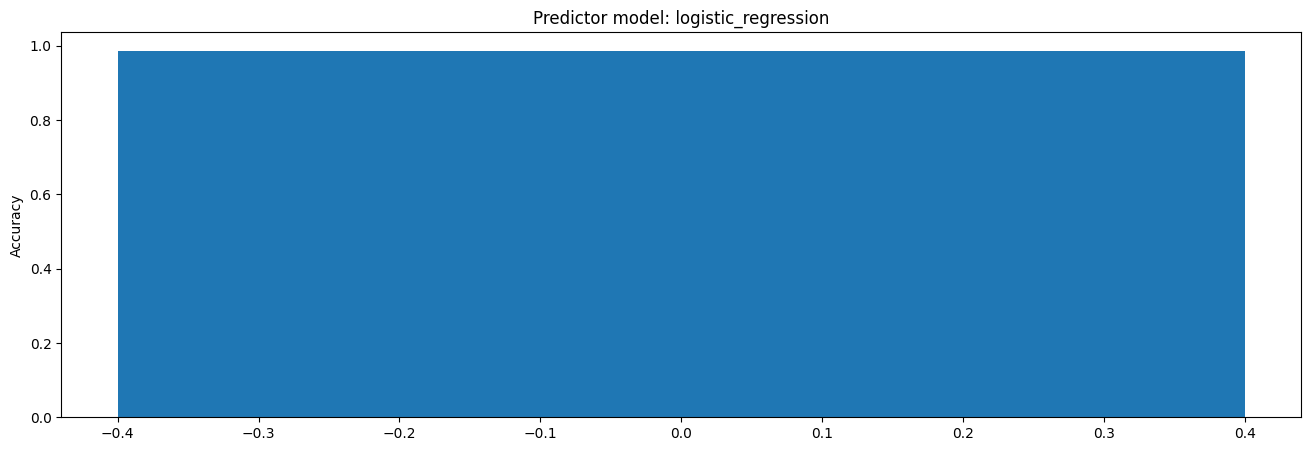

In [37]:
afa_predictor.fit(afa_dataset, 
                  fold = 0, 
                  train_split = 'train', 
                  valid_split = 'val', 
                  fit_again = False)

In [38]:
label_pred = afa_predictor.predict( afa_dataset, fold = 0, split = 'val', n_samples = 1 )

4191/4191 [==============================] - 2s 565us/step


In [39]:
label_pred.shape

(26822, 5, 1)

### Write report

In [48]:
explanation_file = afa_predictor.directory + 'model_report.md'  # +  'reports/' + 'model_report' 
afa_predictor.explain(file= explanation_file, format = 'markdown')

[Errno 2] No such file or directory: 'pandoc'
Error, but instead of markdown format, saving the latex format into the file "../../../data/ts/miiv/fully_observed/predictor_models/logistic_regression/model_report.md" . 
Content of file:

\subsubsection{The AFA predictor model : logistic_regression}
\subparagraph{Model}
The AFA predictor is based on the following submodel: \subparagraph{Fitting}
\begin{figure}\centering\includegraphics[width=0.5 \textwidth]{img/model_report.AFA predictor training.png}\caption{Goodness of fit for afa predictor}\label{fig:img/model_report.AFA predictor training.png}\end{figure}
